In [ ]:
import os
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets
from torchvision import transforms

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Model Configurations
# ----- Model 1 -----
resize1 = 256
datasetPath1 = r""
weightsPath1 = r""
inputImagesDir1 = r""

# ----- Model 2 -----
resize2 = 320
datasetPath2 = r""
weightsPath2 = r""
inputImagesDir2 = r""

# ----- Model 3 -----
resize3 = 256
datasetPath3 = r""
weightsPath3 = r""
inputImagesDir3 = r""

outputDir = r""

In [17]:
# VGG class
class VisualGeometryGroup(nn.Module):
    def __init__(self, output_dim, resize_size):
        super(VisualGeometryGroup, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),    # Conv64
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPool
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Conv128
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPool
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1), # Conv256
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), # Conv256
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPool
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1), # Conv512
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv512
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPool
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv512
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1), # Conv512
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # MaxPool
        )        
        
        self.classifier = nn.Sequential(            
            nn.Linear(512 * int(resize_size // 32) * int(resize_size // 32), 4096),  # Adjust based on input size
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, output_dim),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)
        return x

In [ ]:
def loadModelAndPredict(datasetPath, weightsPath, inputDir, resize_size, modelId):
    # Load class names
    dummy_transform = transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    dataset = datasets.ImageFolder(root=datasetPath, transform=dummy_transform)
    labelNames = dataset.classes
    numLabels = len(labelNames)

    # Load model
    model = VisualGeometryGroup(output_dim=numLabels, resize_size=resize_size).to(device)
    model.load_state_dict(torch.load(weightsPath, map_location=device))
    model.eval()

    # Pre-processing
    transform = transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    # Load images
    images, originals, true_labels, paths = [], [], [], []

    for subdir, dirs, files in os.walk(inputDir):
        for file in sorted(files):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                labelFolder = os.path.basename(subdir)
                fullPath = os.path.join(subdir, file)
                img = Image.open(fullPath).convert('RGB')

                # Map folder name to the class index
                if labelFolder not in labelNames:
                    continue 
                true_label = labelFolder

                images.append(transform(img))
                originals.append(img)
                true_labels.append(true_label)
                paths.append(fullPath)

    # Run inference
    predictions = []
    with torch.no_grad():
        for img_tensor in images:
            input_tensor = img_tensor.unsqueeze(0).to(device)
            output = model(input_tensor)
            _, pred = torch.max(output, 1)
            predictions.append(labelNames[pred.item()])

    return {
        "images": originals,
        "true_labels": true_labels,
        "predictions": predictions,
        "paths": paths,
        "model_id": modelId,
        "class_names": labelNames
    }

In [ ]:
# Inference for all models with individual resize sizes
results1 = loadModelAndPredict(datasetPath1, weightsPath1, inputImagesDir1, resize1, "Model 1")
results2 = loadModelAndPredict(datasetPath2, weightsPath2, inputImagesDir2, resize2, "Model 2")
results3 = loadModelAndPredict(datasetPath3, weightsPath3, inputImagesDir3, resize3, "Model 3")

# Sanity check
assert len(results1["images"]) == len(results2["predictions"]) == len(results3["predictions"])

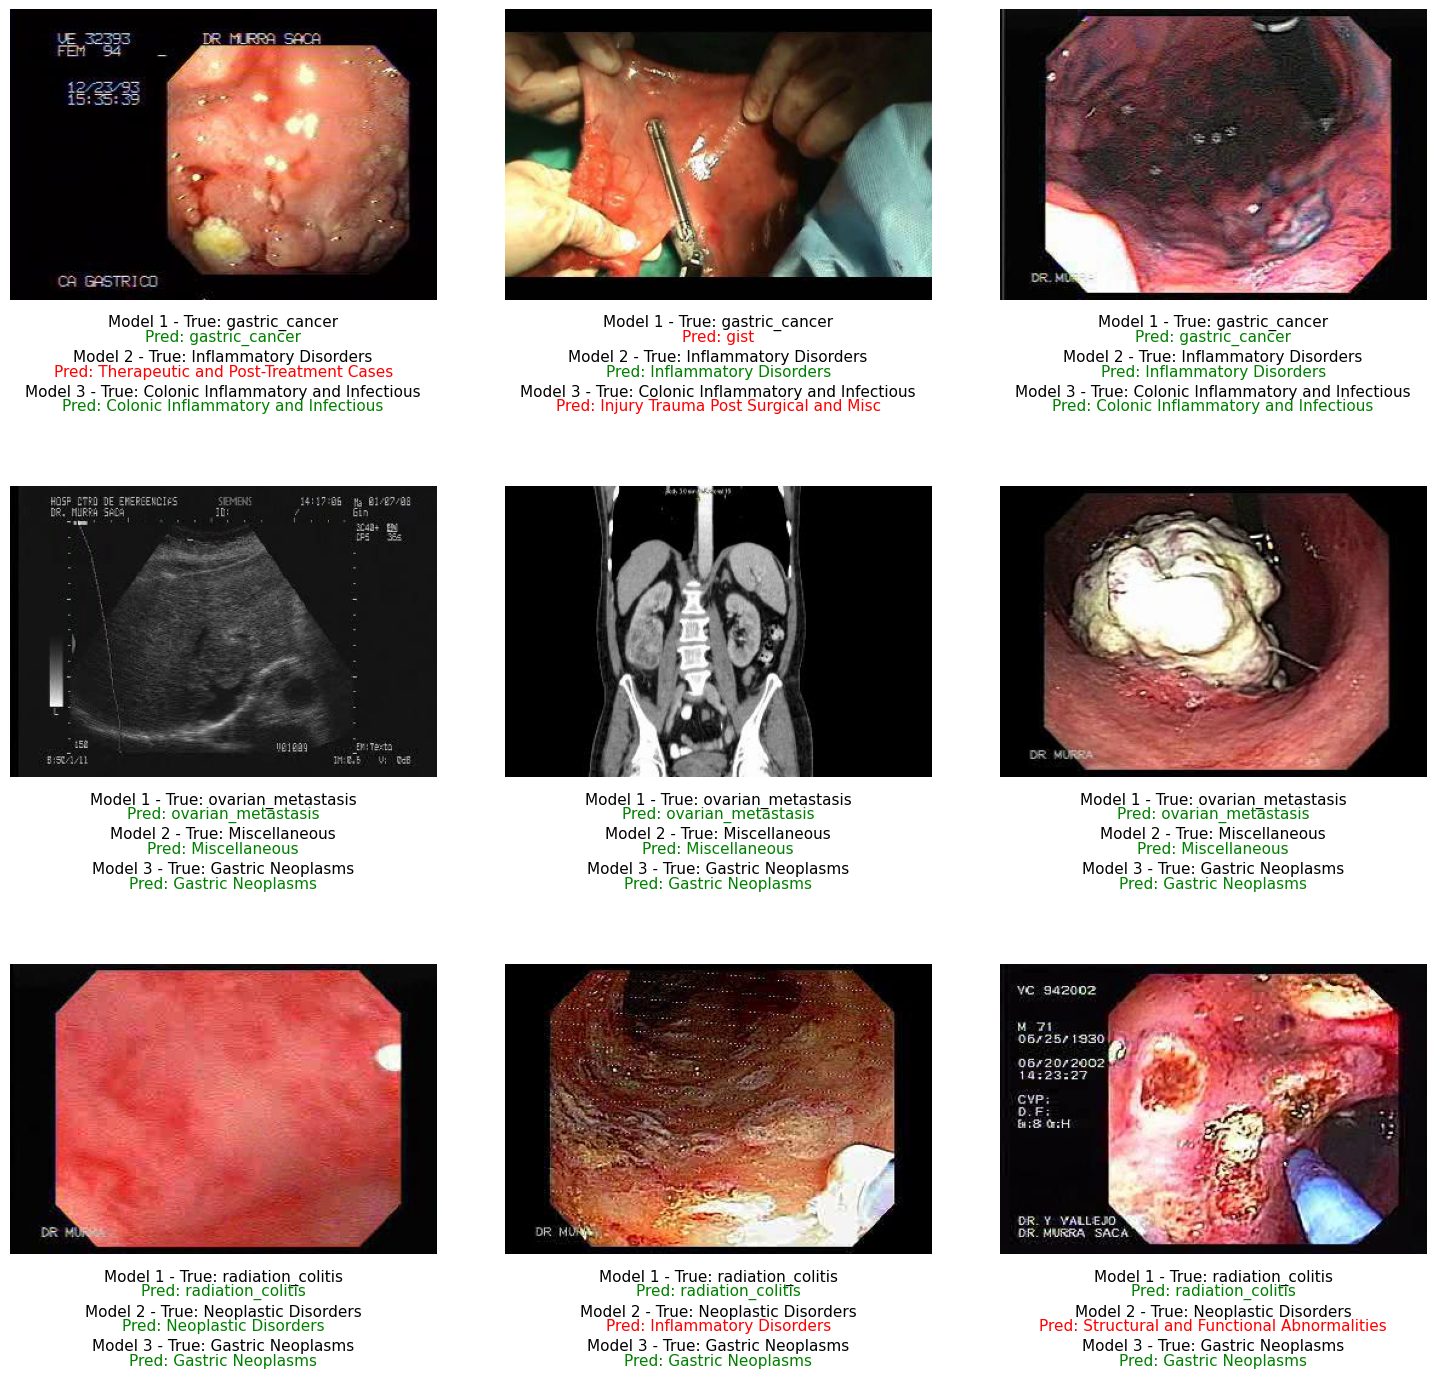

In [ ]:
# Use model 1 images as reference
images = results1["images"]
paths = results1["paths"]
allResults = [results1, results2, results3]

totalImages = len(images)
cols = math.ceil(math.sqrt(totalImages))
rows = math.ceil(totalImages / cols)

plt.figure(figsize=(cols * 5, rows * 5))

for i in range(totalImages):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

    y = -0.05       # Start closer to the image
    fontSize = 11 

    for result in allResults:
        trueLabel = result["true_labels"][i]
        predictedLabel = result["predictions"][i]
        modelName = result["model_id"]
        correct = (trueLabel == predictedLabel)

        # True label (black)
        plt.text(0.5, y, f"{modelName} - True: {trueLabel}", transform=plt.gca().transAxes,
                 fontsize=fontSize, ha='center', va='top', color='black')
        y -= 0.05

        # Prediction - green if correct, red if wrong
        plt.text(0.5, y, f"Pred: {predictedLabel}", transform=plt.gca().transAxes,
                 fontsize=fontSize, ha='center', va='top', color='green' if correct else 'red')
        y -= 0.07  # spacing between models

plt.tight_layout()
os.makedirs(outputDir, exist_ok=True)
final_out = os.path.join(outputDir, "model_comparison_grid.jpg")
plt.savefig(final_out, bbox_inches='tight')
plt.show()